# ROC/AUC analysis with corrected De Long Test

# Setup

In [105]:
# install.packages("dplyr")
# install.packages("pROC")
# install.packages("ggplot2")

In [106]:
library(dplyr)
library(pROC)
library(ggplot2)

In [107]:
input_dir <- "../8_ROC/7-FC/FC_familias-cleaned-LR"                         # CHANGE THIS
output_dir <- "../8_ROC/7-FC/FC_ROC"                                        # CHANGE THIS

# Find all cleaned LR files

In [ ]:
# Scans the main directory for the needed text file
clean_files <- list.files(
  path       = input_dir,
  pattern    = "^.*_cleanLR\\.txt$",                                
  full.names = TRUE
)

# Exclude files with "27" in the filename                     #### Removes 27 aSTR and 27 aSTR + 90 iiSNPs
clean_files <- clean_files[!grepl("27", basename(clean_files))]

if (length(clean_files) == 0) {
  stop("No cleaned files found.")
}

cat("Found", length(clean_files), "cleaned LR files:\n")
print(basename(clean_files))

Found 5 cleaned LR files:
[1] "FC_23aSTR_cleanLR.txt"         "FC_23astr-90iisnp_cleanLR.txt"
[3] "FC_23astr-94iisnp_cleanLR.txt" "FC_90iisnp_cleanLR.txt"       
[5] "FC_94iisnp_cleanLR.txt"       


# Create function to compute ROC +AUC + De Long

In [109]:
compute_roc <- function(file_path, output_dir) {
  # Read LR data
  df <- read.table(file_path, header = TRUE)

  # Get marker panel and relationship names from filename
  panel_name <- strsplit(basename(file_path), "_")[[1]][2]
  rel_name   <- strsplit(basename(file_path), "_")[[1]][1]

  # Column labels
  col_true  <- names(df)[1]
  col_unrel <- names(df)[2]

  # Convert LR to log10(LR)
  LR_true  <- log10(df[[col_true]])
  LR_unrel <- log10(df[[col_unrel]])

  # Labels: 1 = related, 0 = unrelated
  labels <- c(rep(1, length(LR_true)), rep(0, length(LR_unrel)))
  scores <- c(LR_true, LR_unrel)

  # ROC via pROC
  roc_obj <- pROC::roc(
    response  = labels,
    predictor = scores,
    quiet     = TRUE,
    direction = "auto"
  )

  # AUC (numeric)
  auc_val <- as.numeric(pROC::auc(roc_obj))

  # 95% CI for AUC using DeLong (default in pROC)
  ci_auc   <- as.numeric(pROC::ci.auc(roc_obj, conf.level = 0.95))
  ci_lower <- ci_auc[1]
  ci_upper <- ci_auc[3]

  # Get ROC coordinates for plotting (TPR vs FPR)
  roc_coords <- pROC::coords(
    roc_obj,
    x   = "all",
    ret = c("specificity", "sensitivity"),
    transpose = FALSE
  )
  roc_df <- data.frame(
    FPR         = 1 - roc_coords$specificity,
    TPR         = roc_coords$sensitivity,
    Panel       = panel_name,
    Relationship = rel_name
  )

  # Individual ROC plot for this panel
  roc_plot <- ggplot2::ggplot(roc_df, ggplot2::aes(x = FPR, y = TPR)) +
    ggplot2::geom_line(linewidth = 1.1) +
    ggplot2::geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
    ggplot2::labs(
      title = paste0(
        "ROC - ", rel_name, " - ", panel_name,
        " (AUC=", format(auc_val, digits = 4), ")"
      ),
      x = "False Positive Rate (1 - Specificity)",
      y = "True Positive Rate (Sensitivity)"
    ) +
    ggplot2::theme_minimal(base_size = 14)

  roc_png <- file.path(
    output_dir,
    paste0("ROC_", rel_name, "_", panel_name, ".png")
  )
  ggplot2::ggsave(roc_png, plot = roc_plot, width = 6, height = 5, dpi = 300)

  cat("Saved individual ROC plot:", roc_png, "\n")

  # Summary row for AUC table, including 95% CI for AUC
  auc_row <- data.frame(
    Panel        = panel_name,
    AUC          = auc_val,
    AUC_CI_lower = ci_lower,
    AUC_CI_upper = ci_upper,
    N_sim        = nrow(df),
    stringsAsFactors = FALSE
  )

  # Return:
  # - summary row for AUC table
  # - roc_df for combined plotting
  # - roc_obj for DeLong AUC comparisons
  list(
    auc_row = auc_row,
    roc_df  = roc_df,
    roc_obj = roc_obj
  )
}

# Loop over all panels

In [110]:
auc_list    <- vector("list", length(clean_files))
rocdf_list  <- vector("list", length(clean_files))
roc_list    <- vector("list", length(clean_files))
panel_names <- character(length(clean_files))

for (i in seq_along(clean_files)) {
  f <- clean_files[i]
  cat("\nProcessing:", basename(f), "\n")
  res <- compute_roc(f, output_dir)

  # Store AUC summary row and ROC coordinates
  auc_list[[i]]   <- res$auc_row
  rocdf_list[[i]] <- res$roc_df

  # Store full ROC object and its panel name for DeLong's test
  roc_list[[i]]      <- res$roc_obj
  panel_names[i]     <- res$auc_row$Panel
}

# Name the ROC list elements by panel, for easier access and plotting
names(roc_list) <- panel_names

auc_table <- bind_rows(auc_list)
roc_all   <- bind_rows(rocdf_list)



Processing: FC_23aSTR_cleanLR.txt 
Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_23aSTR.png 

Processing: FC_23astr-90iisnp_cleanLR.txt 
Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_23astr-90iisnp.png 

Processing: FC_23astr-94iisnp_cleanLR.txt 
Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_23astr-94iisnp.png 

Processing: FC_90iisnp_cleanLR.txt 
Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_90iisnp.png 

Processing: FC_94iisnp_cleanLR.txt 
Saved individual ROC plot: ../8_ROC/7-FC/FC_ROC/ROC_FC_94iisnp.png 


# Save AUC summary table with De Long Tes

In [111]:

# Choose reference panel for DeLong's test (first panel in AUC table)
reference_panel <- as.character(auc_table$Panel[1])

# Initialize columns for DeLong comparisons
auc_table$AUC_diff_vs_ref   <- NA_real_
auc_table$AUC_diff_CI_lower <- NA_real_
auc_table$AUC_diff_CI_upper <- NA_real_
auc_table$p_Delong          <- NA_real_

# Compute DeLong test for each non-reference panel, including 95% CI for AUC difference
for (i in seq_len(nrow(auc_table))) {
  p <- as.character(auc_table$Panel[i])

  if (!is.na(p) && p != reference_panel) {
    test_res <- suppressWarnings(
      pROC::roc.test(
        roc_list[[p]],
        roc_list[[reference_panel]],
        method      = "delong",
        paired      = TRUE,
        conf.level  = 0.95
      )
    )
    # AUCs of panel and reference
    auc_panel <- as.numeric(test_res$estimate[1])
    auc_ref   <- as.numeric(test_res$estimate[2])
    auc_diff  <- auc_panel - auc_ref
    
    # AUC difference and its 95% CI
    auc_table$AUC_diff_vs_ref[i]   <- auc_diff
    auc_table$AUC_diff_CI_lower[i] <- as.numeric(test_res$conf.int[1])
    auc_table$AUC_diff_CI_upper[i] <- as.numeric(test_res$conf.int[2])
    auc_table$p_Delong[i]          <- as.numeric(test_res$p.value)
  }
}

# Multiple-testing corrections and significance flags at alpha = 0.01
auc_table <- auc_table %>%
  mutate(
    # p_Delong_BH      = ifelse(is.na(p_Delong), NA_real_, p.adjust(p_Delong, method = "BH")),
    p_Delong_Holm    = ifelse(is.na(p_Delong), NA_real_, p.adjust(p_Delong, method = "holm")),
    # Significant_01   = !is.na(p_Delong)      & p_Delong      < 0.01,
    # BH_significant_01   = !is.na(p_Delong_BH)   & p_Delong_BH   < 0.01,
    Holm_significant_01 = !is.na(p_Delong_Holm) & p_Delong_Holm < 0.01
  )

# Generate name for summary table (AUC) and plots (ROC)
summaries_label <- strsplit(basename(clean_files[1]), "_")[[1]][1]

auc_outfile <- file.path(output_dir, paste0("AUC_summary_", summaries_label, "_panels.txt"))

# Enforce desired panel order in AUC table (case-insensitive, but keep original labels)
desired_order <- c(
  "23aSTR",
  "27aSTR",
  "90iiSNP",
  "94iiSNP",
  "23aSTR-90iiSNP",
  "23aSTR-94iiSNP",
  "27aSTR-94iiSNP"
)

auc_table <- auc_table %>%
  mutate(
    Panel       = as.character(Panel),
    Panel_lower = tolower(Panel),
    Panel_order = match(Panel_lower, tolower(desired_order))
  ) %>%
  arrange(is.na(Panel_order), Panel_order, Panel) %>%
  select(-Panel_lower, -Panel_order)

write.table(
  auc_table,
  file      = auc_outfile,
  sep       = "\t",
  quote     = FALSE,
  row.names = FALSE
)

cat("\nAUC summary table saved to:", auc_outfile, "\n")
print(auc_table)


AUC summary table saved to: ../8_ROC/7-FC/FC_ROC/AUC_summary_FC_panels.txt 
           Panel       AUC AUC_CI_lower AUC_CI_upper N_sim AUC_diff_vs_ref
1         23aSTR 0.8419127    0.8365616    0.8472639 10000              NA
2        90iisnp 0.7968228    0.7907579    0.8028876 10000     -0.04508998
3        94iisnp 0.8104133    0.8045383    0.8162883 10000     -0.03149947
4 23astr-90iisnp 0.8980137    0.8938127    0.9022147 10000      0.05610093
5 23astr-94iisnp 0.9039524    0.8998978    0.9080069 10000      0.06203963
  AUC_diff_CI_lower AUC_diff_CI_upper     p_Delong p_Delong_Holm
1                NA                NA           NA            NA
2       -0.05318908       -0.03699088 1.013770e-27  2.027540e-27
3       -0.03945068       -0.02354826 8.191755e-15  8.191755e-15
4        0.04931148        0.06289038 5.461929e-59  1.638579e-58
5        0.05532193        0.06875732 3.142498e-73  1.256999e-72
  Holm_significant_01
1               FALSE
2                TRUE
3                

# Plot AUC with 95% CI error bars for each panel


AUC with 95% CI plot saved to: ../8_ROC/7-FC/FC_ROC/AUC_with_95CI_FC_panels.png 


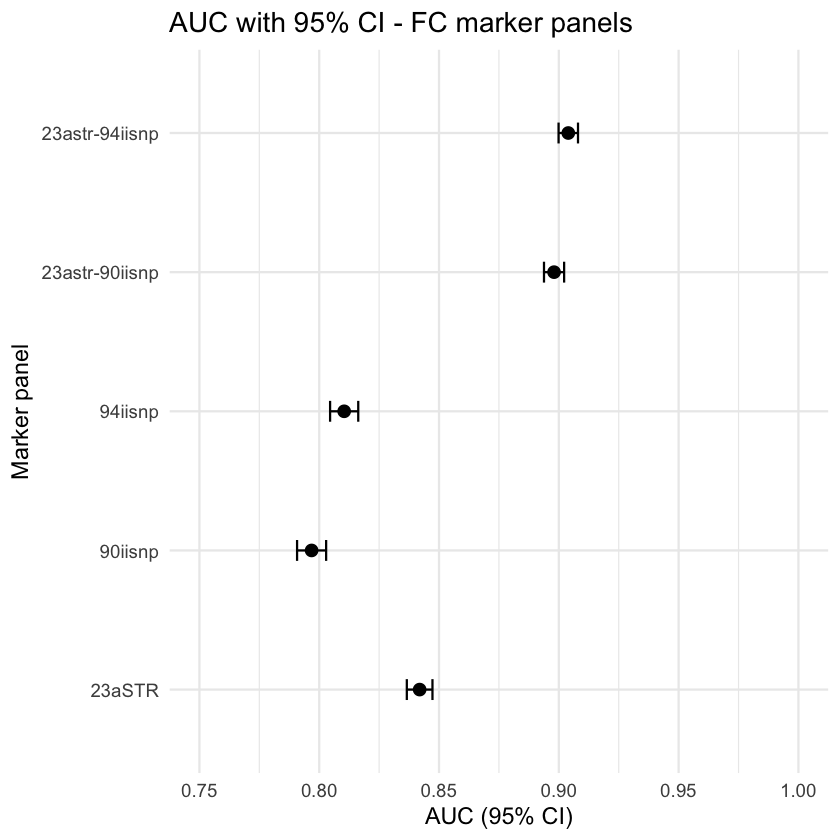

In [112]:
# Ensure panel ordering matches AUC table ordering
auc_table$Panel <- factor(auc_table$Panel, levels = auc_table$Panel)

auc_ci_plot <- ggplot(auc_table,
                      aes(x = Panel, y = AUC)) +
  geom_point(size = 3) +
  geom_errorbar(aes(ymin = AUC_CI_lower,
                    ymax = AUC_CI_upper),
                width = 0.15) +
  coord_flip(ylim = c(0.75, 1)) +
  theme_minimal(base_size = 14) +
  labs(
    title = paste0("AUC with 95% CI - ", summaries_label, " marker panels"),
    x     = "Marker panel",
    y     = "AUC (95% CI)"
  )

auc_ci_png <- file.path(output_dir,
                        paste0("AUC_with_95CI_", summaries_label, "_panels.png"))
ggsave(auc_ci_png, plot = auc_ci_plot, width = 20, height = 5, dpi = 300)

print(auc_ci_plot)
cat("\nAUC with 95% CI plot saved to:", auc_ci_png, "\n")

# Combined ROC plot (all panels together)


Combined ROC plot saved to: ../8_ROC/7-FC/FC_ROC/ROC_FC_all_panels.png 


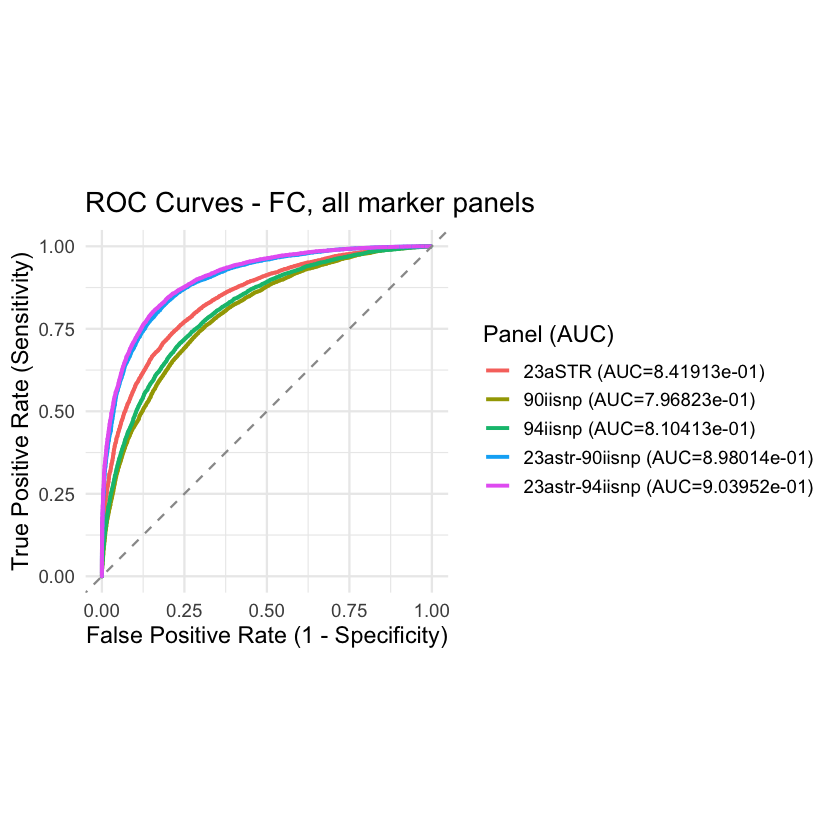

In [113]:
# Create labels including AUC in legend
auc_labels <- auc_table %>%
  mutate(
    PanelLabel = paste0(
      Panel,
      " (AUC=",
      format(as.numeric(AUC), digits = 6, scientific = TRUE),
      ")"
    )
  )

# Map raw Panel names to Panel Label for legend
panel_label_map <- setNames(auc_labels$PanelLabel, auc_labels$Panel)

# Enforce panel order for ROC curves
roc_all <- roc_all %>%
  mutate(
    Panel       = as.character(Panel),
    Panel_lower = tolower(Panel),
    Panel_order = match(Panel_lower, tolower(desired_order))
  ) %>%
  arrange(is.na(Panel_order), Panel_order) %>%
  mutate(
    Panel = factor(Panel, levels = unique(Panel))
  ) %>%
  select(-Panel_lower, -Panel_order)

# Build combined ROC plot
p_combined <- ggplot(roc_all, aes(x = FPR, y = TPR, color = Panel)) +
  geom_line(linewidth = 1.1) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "grey60") +
  coord_equal() +
  scale_color_discrete(labels = panel_label_map[levels(roc_all$Panel)]) +
  labs(
    title = paste0("ROC Curves - ", summaries_label, ", all marker panels"),
    x     = "False Positive Rate (1 - Specificity)",
    y     = "True Positive Rate (Sensitivity)",
    color = "Panel (AUC)"
  ) +
  theme_minimal(base_size = 14)

combined_png <- file.path(output_dir, paste0("ROC_", summaries_label, "_all_panels.png"))
ggsave(combined_png, plot = p_combined, width = 8, height = 7, dpi = 300)

print(p_combined)

cat("\nCombined ROC plot saved to:", combined_png, "\n")